# **recurrent neural network**

### init

In [1]:
import torch
from utils.data_util import HackerNewsContext
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

g = torch.Generator(device=device).manual_seed(0)

class EmbeddingsRNN:
    def __init__(self, embedding_dims, context_size, batch_size, hidden_units, device):
        self.batch_size = batch_size
        self.embedding_dims = embedding_dims
        self.context_size = context_size
        self.device = device
        self.hidden_units = hidden_units
        self.g = torch.Generator(device=self.device).manual_seed(0)
        self.C = torch.randn((28, self.embedding_dims), generator=self.g, device=self.device) * 0.01# embedding lookup-table
        self.Wxh = torch.randn((self.embedding_dims, self.hidden_units), generator=self.g, device=self.device) * (2/(self.embedding_dims))**0.5 # weights input to hidden
        self.Whh = torch.randn((self.hidden_units, self.hidden_units), generator=self.g, device=self.device) * (2/100)**0.5 # weights hidden to hidden
        self.bh = torch.randn((1, self.hidden_units), generator=self.g, device=self.device) * 0.01 # biases hidden layer
        self.Who = torch.randn((self.hidden_units, 28), generator=self.g, device=self.device) * (2/100)**0.5 # weights hidden to output
        self.bo = torch.randn(28, generator=self.g, device=self.device) * 0.01 # biases output layer
        self.parameters = [self.C, self.Wxh, self.Whh, self.bh, self.Who, self.bo]
        for p in self.parameters:
            p.requires_grad = True

    def forward(self, X, y):
        # X comes in as (batch_size, context_size, 28)
        # y comes in as (batch_size)
        ys = torch.cat((
            torch.argmax(X, dim=2)[:, 1:],
            torch.unsqueeze(y, dim=1)),
            dim=1) # (batch_size, context_size)

        embeddings, hs, logits = {}, {}, {}
        self.loss = 0
        hs[-1] = torch.zeros(self.batch_size, self.hidden_units, device=device)

        for t in range(self.context_size):
            embeddings[t] = X[:, t, :]@self.C # (batch_size, 1, 28) @ (28, embedding_dims) = (batch_size, embedding_dims)
            hs[t] = F.tanh(embeddings[t] @ self.Wxh + hs[t-1] @ self.Whh + self.bh) # (batch_size, hidden_units)
            logits[t] = hs[t] @ self.Who + self.bo # (batch_size, 1, 28)
            self.loss += F.cross_entropy(logits[t], ys[:, t])
        return self.loss.item()
            
    def backward(self):
        for p in self.parameters:
            p.grad = None
        self.loss.backward()

    def update_params(self, lr, clip_value=None):
        for p in self.parameters:
            if p.grad is not None:
                if clip_value is not None:
                    p.grad.data = torch.clamp(p.grad.data, -clip_value, clip_value)
                p.data += -lr * p.grad


    def sample(self, ctoi, itoc):
        text = ''
        n = 0
        nll = 0.0
        context = ['<>'] * self.context_size

        with torch.no_grad():
            while True:
                embeddings, hs, logits, probs, ixs = {}, {}, {}, [], []
                hs[-1] = torch.zeros_like(self.bh, device=device)
                X = F.one_hot(torch.tensor([ctoi[c] for c in context], device=self.device), num_classes=28).float()


                for t in range(self.context_size):
                    embeddings[t] = (X[t, :]@self.C)
                    hs[t] = F.tanh(embeddings[t] @ self.Wxh + hs[t-1] @ self.Whh + self.bh)
                    logits[t] = hs[t] @ self.Who + self.bo
                    probs.append(F.softmax(logits[t], dim=1))
                    ixs.append(torch.multinomial(probs[-1], num_samples=1, replacement=True, generator=self.g).item())

                # break if end-character was sampled
                if ixs[t]==ctoi['<>']:
                    break
                    
                # update params
                context = context[1:] + [itoc[ixs[-1]]]
                text += itoc[ixs[-1]]
                n += 1

                # calculate negative log loss
                p = probs[-1][0][ixs[-1]].log().item()
                nll -= p
            return text, nll/n

Using mps device


### initialize hyperparameters

In [2]:
embedding_dims = 8
context_size = 16
batch_size = 1024
hidden_units = 512

### find initial learning rate

Text(0, 0.5, 'Negative Log Likelihood')

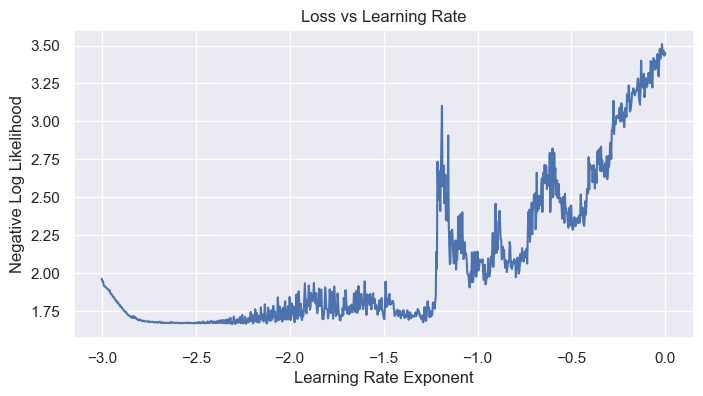

In [3]:
training_data = HackerNewsContext(train=True, context_size=context_size, number_of_strings=30000)
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=False, drop_last=True)
lr_exps = torch.linspace(-3, 0, 1000)
lrs = 10**lr_exps
iterator = iter(train_dataloader)
losses = []
nn1 = EmbeddingsRNN(embedding_dims=embedding_dims, context_size=context_size, batch_size=batch_size, hidden_units=hidden_units, device=device)

for lr in lrs:
    X, y = next(iterator)
    X, y = X.to(device), y.to(device) # (batch_size, context_size, 28)

    loss = nn1.forward(X=X, y=y)
    nn1.backward()
    nn1.update_params(lr=lr, clip_value=5.0)
    losses.append(loss)

fig, ax = plt.subplots(figsize=(8,4))
sns.set_style()
plt.plot(lr_exps, np.log10(losses))
ax.set_title('Loss vs Learning Rate')
ax.set_xlabel('Learning Rate Exponent')
ax.set_ylabel('Negative Log Likelihood')

### instantiate rnn

In [4]:
rnn = EmbeddingsRNN(
    embedding_dims=embedding_dims,
    context_size=context_size,
    batch_size=batch_size,
    hidden_units=hidden_units,
    device=device
)

### model training

In [5]:
lr = 10**-1.0
epochs = 50

for epoch in range(epochs):
    training_data = HackerNewsContext(train=True, context_size=context_size, number_of_strings=10000)
    train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=False, drop_last=True)
    losses = []
    for batch, (X, y) in enumerate(train_dataloader):
        X = X.to(device)
        y = y.to(device)
        losses.append(rnn.forward(X, y))
        rnn.backward()
        rnn.update_params(lr=lr, clip_value=5.0)
    print(f'epoch: {epoch+1} --- average loss: {(np.mean(losses)/context_size):.4f}')
    if epoch%5==0 and epoch!=0:
        lr /= 2
        print(f'new learning rate: {lr:.4f}')

epoch: 1 --- average loss: 3.4218
epoch: 2 --- average loss: 1.9871
epoch: 3 --- average loss: 1.8431
epoch: 4 --- average loss: 1.7770
epoch: 5 --- average loss: 1.7346
epoch: 6 --- average loss: 1.7077
new learning rate: 0.0500
epoch: 7 --- average loss: 1.5852
epoch: 8 --- average loss: 1.5771
epoch: 9 --- average loss: 1.5716
epoch: 10 --- average loss: 1.5660
epoch: 11 --- average loss: 1.5547
new learning rate: 0.0250
epoch: 12 --- average loss: 1.5584
epoch: 13 --- average loss: 1.5535
epoch: 14 --- average loss: 1.5527
epoch: 15 --- average loss: 1.5536
epoch: 16 --- average loss: 1.5477
new learning rate: 0.0125
epoch: 17 --- average loss: 1.5489
epoch: 18 --- average loss: 1.5428
epoch: 19 --- average loss: 1.5427
epoch: 20 --- average loss: 1.5473
epoch: 21 --- average loss: 1.5396
new learning rate: 0.0063
epoch: 22 --- average loss: 1.5404
epoch: 23 --- average loss: 1.5421
epoch: 24 --- average loss: 1.5414
epoch: 25 --- average loss: 1.5411
epoch: 26 --- average loss: 1.

### sample from model

In [10]:
text, nll = rnn.sample(
    ctoi=training_data.ctoi,
    itoc=training_data.itoc
)
print(text)
print(f'negative log likelihood: {nll:.4f}')

a hrefhttpsivemlosspecisions for any mass and the us none out once they were pabam is just be to himbled nations as google there is a hrefhttpbgstrackacry distance goos not have before after anyway to get it currency or a new just dods sure the mutotoma  jra  fas i agree is that work hard to creating pay the usil my vm carbone to a peserver code for the subjective done people accusetor wia still access of newcy option not so structure obdriding in the us savery think about thinks i have this what yet a koding on the burked and in indecle that have you comes in their volobes help dispare totding about on a sune ideapanovewtreg ver im sure anywhere also most contation is this an apple enalues often piece to ters created gaints avillate python flee know what i think it  san running opiential interesting all the next in python  the problems nods like this is single famages to build l  al tracinsuge the bulles untild between voinpor facehaqors look the windouses are stobledy cost aguesting 